In [1]:
import os
import sys

data_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if data_path not in sys.path:
    sys.path.append(data_path)

print("Final sys.path:", sys.path)

Final sys.path: ['/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/benchmarks/stage_2_all_strategies', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '__editable__.lag_llama-0.1.0.finder.__path_hook__', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/opt/anaconda3/lib/python3.12/site-packages/setuptools/_vendor', '/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial']


In [2]:
pwd

'/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/benchmarks/stage_2_all_strategies'

In [3]:
pip install git+https://github.com/SalesforceAIResearch/uni2ts.git

  Cloning https://github.com/SalesforceAIResearch/uni2ts.git to /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-3412wqxe
  Running command git clone --filter=blob:none --quiet https://github.com/SalesforceAIResearch/uni2ts.git /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-3412wqxe
  Resolved https://github.com/SalesforceAIResearch/uni2ts.git to commit 6166d284f467da7befc206f6a5b6b2bc1a794a87
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/365M [00:00<?, ?B/s]


Moirai Sliding Window Forecast Metrics:
MAE: 33.8020
MSE: 1613.5207
RMSE: 40.1687
Z-NormalizedMAE: 0.5811
Z-NormalizedMSE: 0.4769
Z-NormalizedRMSE: 0.6906
MAPE: 0.7681
SMAPE: 0.7677
MASE: nan
DirectionalAccuracy: 50.0000


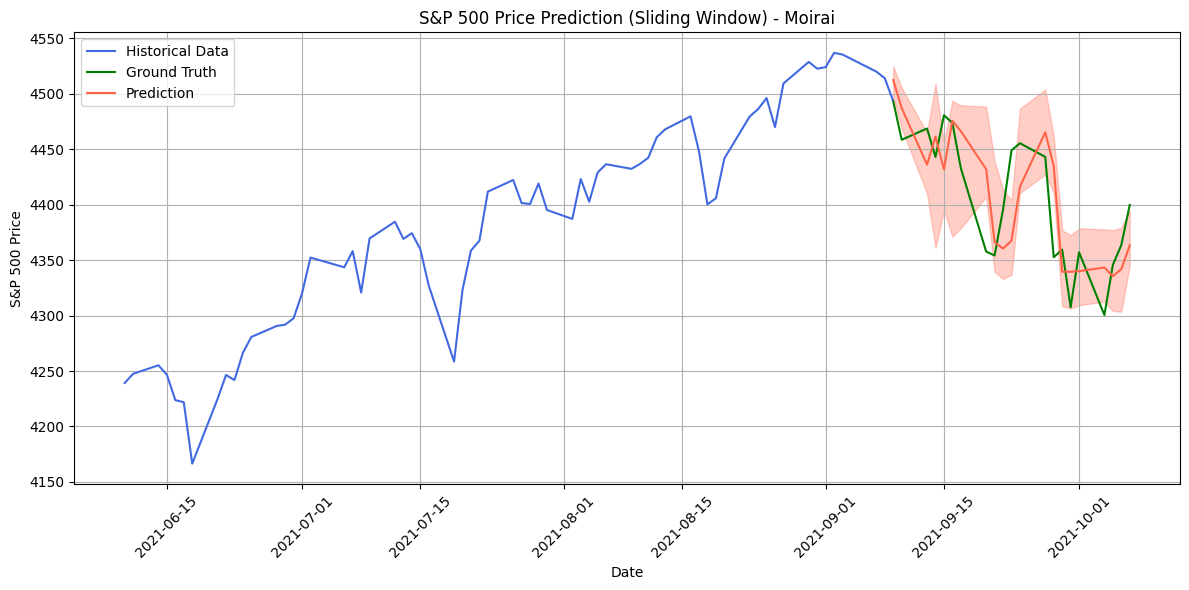

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics

CONTEXT_WINDOW = 63
FORECAST_STEPS = 21
PREDICTION_LENGTH = 1  

model = MoiraiForecast(
    module=MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-base"),
    prediction_length=PREDICTION_LENGTH,
    context_length=CONTEXT_WINDOW,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=32)

def generate_single_forecast(context_data, context_start_date):
    """Generate single-step forecast with Moirai (fixed)"""
    # Flatten to 1D and create pandas Series
    context_data_flat = np.asarray(context_data).flatten()  # Force 1D
    
    dates = pd.date_range(
        start=context_start_date,
        periods=len(context_data_flat),
        freq="D"
    )
    context_series = pd.Series(context_data_flat, index=dates)
    
    # Create dataset and generate forecast
    dataset = PandasDataset({"target": context_series})
    forecast = list(predictor.predict(dataset))[0]
    
    # Extract quantiles
    samples = forecast.samples
    low = np.percentile(samples, 10, axis=0).item()  # .item() for scalar
    median = np.percentile(samples, 50, axis=0).item()
    high = np.percentile(samples, 90, axis=0).item()
    
    return low, median, high

# Rest of the functions remain identical to Lag-Llama version
def generate_sliding_window_forecasts(data, start_idx):
    """Robust sliding window implementation with dimension handling"""
    all_forecasts = {
        'median': [],
        'low': [],
        'high': [],
        'dates': []
    }
    
    for i in range(FORECAST_STEPS):
        current_idx = start_idx + i
        context_start = current_idx - CONTEXT_WINDOW
        
        # Get and flatten context window
        context_data = data['Close'].iloc[context_start:current_idx].to_numpy().flatten()
        
        # Validate dimensions
        if context_data.ndim != 1:
            raise ValueError(f"Expected 1D input, got {context_data.ndim}D")
        if len(context_data) != CONTEXT_WINDOW:
            raise ValueError(f"Invalid context window size: {len(context_data)}")
        
        # Generate forecast
        low, median, high = generate_single_forecast(
            context_data, 
            data['Date'].iloc[context_start]
        )
        
        # Store results
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(data['Date'].iloc[current_idx])
    
    return all_forecasts

def plot_forecast_with_sliding_window(data, start_idx, forecasts):
    """Fixed visualization"""
    plt.figure(figsize=(12, 6))
    
    # Plot historical context
    context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx + 1]
    plt.plot(context_data['Date'], context_data['Close'], color='royalblue', label='Historical Data')
    
    # Plot actual prices
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'], color='green', label='Ground Truth')
    
    # Plot forecasts
    plt.plot(forecasts['dates'], forecasts['median'], color='tomato', label='Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title('S&P 500 Price Prediction (Sliding Window) - Moirai')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution (unchanged)
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

target_date = pd.Timestamp('2021-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# Validate sufficient history
if start_idx < CONTEXT_WINDOW:
    raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")

# Generate forecasts
forecasts = generate_sliding_window_forecasts(sp500_d, start_idx)

# Calculate metrics
actual_values = sp500_d['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
metrics = calculate_metrics(actual_values, forecasts['median'])

print("\nMoirai Sliding Window Forecast Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}" if value is not None else f"{metric_name}: N/A")

# Plot results
plot_forecast_with_sliding_window(sp500_d, start_idx, forecasts)


Moirai Recursive Forecast Metrics:
MAE: 841.8665
MSE: 1057138.5383
RMSE: 1028.1724
Z-NormalizedMAE: 6.6990
Z-NormalizedMSE: 66.9376
Z-NormalizedRMSE: 8.1815
MAPE: 18.2900
SMAPE: 21.1811
MASE: nan
DirectionalAccuracy: 39.2857


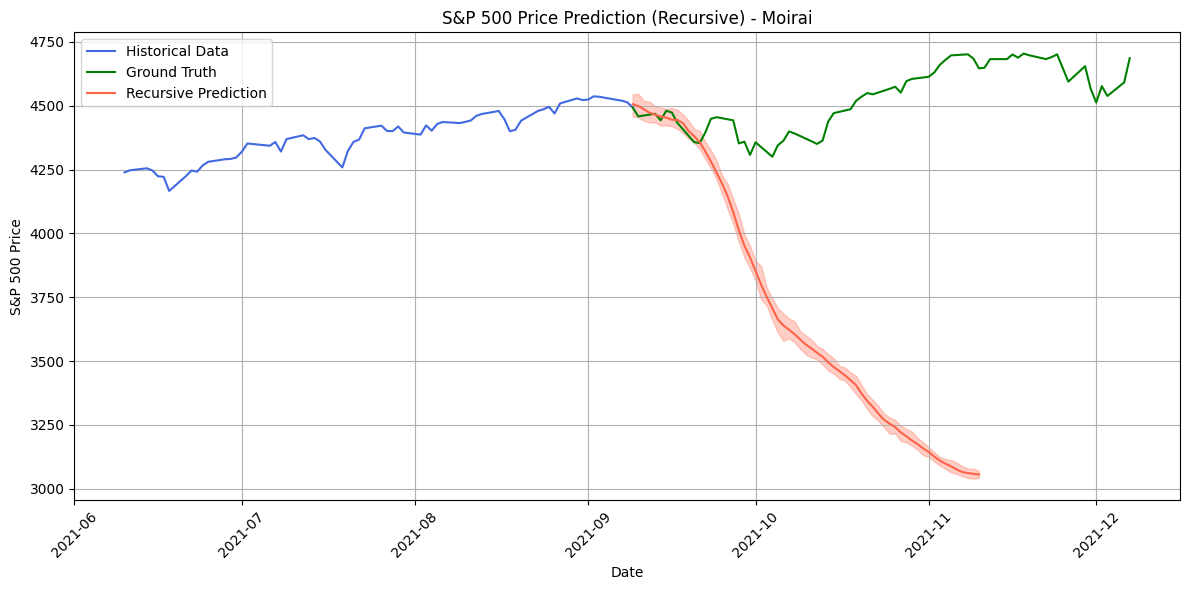

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

from data.snp500 import snp500_daily
from utils.metrics import calculate_metrics

CONTEXT_WINDOW = 560
FORECAST_STEPS = 63
PREDICTION_LENGTH = 1  

model = MoiraiForecast(
    module=MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-large"),
    prediction_length=PREDICTION_LENGTH,
    context_length=CONTEXT_WINDOW,
    patch_size="auto",
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)
predictor = model.create_predictor(batch_size=32)

def generate_single_forecast(context_data, context_start_date):
    """Generate single-step forecast with Moirai (fixed)"""
    # Flatten to 1D and create pandas Series
    context_data_flat = np.asarray(context_data).flatten()  # Force 1D
    
    dates = pd.date_range(
        start=context_start_date,
        periods=len(context_data_flat),
        freq="D"
    )
    context_series = pd.Series(context_data_flat, index=dates)
    
    # Create dataset and generate forecast
    dataset = PandasDataset({"target": context_series})
    forecast = list(predictor.predict(dataset))[0]
    
    # Extract quantiles
    samples = forecast.samples
    low = np.percentile(samples, 10, axis=0).item()  # .item() for scalar
    median = np.percentile(samples, 50, axis=0).item()
    high = np.percentile(samples, 90, axis=0).item()
    
    return low, median, high

def generate_recursive_forecasts(data, start_idx):
    """Recursive forecasting implementation for Moirai"""
    all_forecasts = {
        'median': [],
        'low': [],
        'high': [],
        'dates': []
    }
    
    # Initialize with actual historical data
    context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW:start_idx].to_numpy().flatten()
    
    # Calculate all forecast dates upfront to ensure proper length
    forecast_dates = pd.date_range(
        start=data['Date'].iloc[start_idx],
        periods=FORECAST_STEPS,
        freq='D'
    )
    
    # Start date for context window
    context_start_date = data['Date'].iloc[start_idx - CONTEXT_WINDOW]
    
    for i in range(FORECAST_STEPS):
        # Generate forecast using the current context window
        low, median, high = generate_single_forecast(
            context_data,
            context_start_date
        )
        
        # Store results with proper date alignment
        all_forecasts['median'].append(median)
        all_forecasts['low'].append(low)
        all_forecasts['high'].append(high)
        all_forecasts['dates'].append(forecast_dates[i])
        
        # Update context window: remove oldest value, add latest prediction
        context_data = np.append(context_data[1:], median)
        
        # Move context start date forward
        context_start_date += pd.Timedelta(days=1)
        
        # Validation checks
        assert len(context_data) == CONTEXT_WINDOW, "Context window size changed"
        assert not np.isnan(median), "NaN value in prediction"
        
    # Verify forecast length
    assert len(all_forecasts['dates']) == FORECAST_STEPS, "Incorrect forecast length"
    assert all_forecasts['dates'][-1] == forecast_dates[-1], "Date misalignment"
    
    return all_forecasts

def plot_forecast_with_recursive(data, start_idx, forecasts):
    """Visualization for recursive forecasts"""
    plt.figure(figsize=(12, 6))
    
    # Historical context
    # context_data = data.iloc[start_idx - CONTEXT_WINDOW:start_idx]
    context_data = data.iloc[start_idx - 63:start_idx + 1]
    plt.plot(context_data['Date'], context_data['Close'], 
             color='royalblue', label='Historical Data')
    
    # Actual prices (if available)
    actual_data = data.iloc[start_idx:start_idx + FORECAST_STEPS]
    plt.plot(actual_data['Date'], actual_data['Close'], 
             color='green', label='Ground Truth')
    
    # Recursive predictions
    plt.plot(forecasts['dates'], forecasts['median'], 
             color='tomato', label='Recursive Prediction')
    plt.fill_between(forecasts['dates'], forecasts['low'], forecasts['high'], 
                     color='tomato', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Price')
    plt.title('S&P 500 Price Prediction (Recursive) - Moirai')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution (modified for recursive)
sp500_d = snp500_daily.reset_index()[["Date", "Close"]]
sp500_d["Date"] = pd.to_datetime(sp500_d["Date"])

target_date = pd.Timestamp('2021-09-09')
start_idx = sp500_d[sp500_d['Date'] <= target_date].index[-1]

# Validate sufficient history
if start_idx < CONTEXT_WINDOW:
    raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")

# Generate recursive forecasts
forecasts = generate_recursive_forecasts(sp500_d, start_idx)

# Calculate metrics
actual_values = sp500_d['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
metrics = calculate_metrics(actual_values, forecasts['median'])

print("\nMoirai Recursive Forecast Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}" if value is not None else f"{metric_name}: N/A")

# Plot results
plot_forecast_with_recursive(sp500_d, start_idx, forecasts)